<a href="https://colab.research.google.com/github/MRIGAANKSh/ML_/blob/main/cloudai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install pandas numpy matplotlib scikit-learn tensorflow joblib boto3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 5.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import joblib
import boto3


In [3]:
# Function to generate synthetic data
def generate_synthetic_data(num_hours=1000):
    np.random.seed(42)
    time = pd.date_range(start='2023-01-01', periods=num_hours, freq='H')
    # Simulate CPU usage with daily seasonality and some noise
    cpu_usage = 50 + 30 * np.sin(2 * np.pi * time.hour / 24) + np.random.normal(0, 5, num_hours)
    # Simulate Memory usage similarly
    memory_usage = 60 + 25 * np.sin(2 * np.pi * time.hour / 24 + np.pi/4) + np.random.normal(0, 5, num_hours)
    data = pd.DataFrame({
        'timestamp': time,
        'cpu_usage': cpu_usage,
        'memory_usage': memory_usage
    })
    return data

# Generate the data
data = generate_synthetic_data()

# Set timestamp as index
data.set_index('timestamp', inplace=True)

# Display the first few rows
data.head()


<ipython-input-3-09b6c4a0f962>:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time = pd.date_range(start='2023-01-01', periods=num_hours, freq='H')


,cpu_usage,memory_usage
timestamp,,
2023-01-01 00:00:00,52.483571,84.674447
2023-01-01 01:00:00,57.073250,86.273804
2023-01-01 02:00:00,68.238443,84.446298
2023-01-01 03:00:00,78.828353,81.765316
2023-01-01 04:00:00,74.809995,87.639262


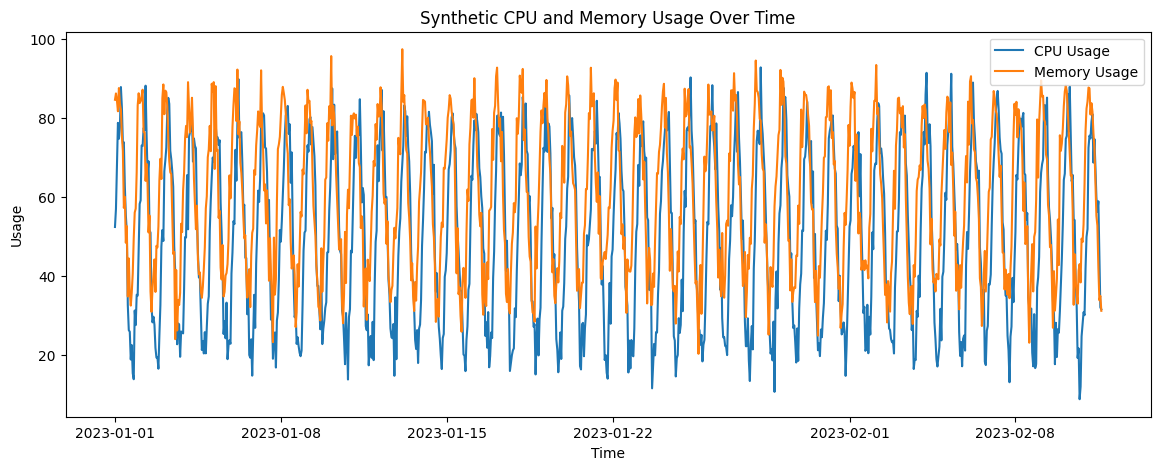

In [4]:
plt.figure(figsize=(14, 5))
plt.plot(data['cpu_usage'], label='CPU Usage')
plt.plot(data['memory_usage'], label='Memory Usage')
plt.title('Synthetic CPU and Memory Usage Over Time')
plt.xlabel('Time')
plt.ylabel('Usage')
plt.legend()
plt.show()


In [5]:
# Feature engineering
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek

# Add moving averages
data['cpu_ma_24'] = data['cpu_usage'].rolling(window=24).mean()
data['memory_ma_24'] = data['memory_usage'].rolling(window=24).mean()

# Drop rows with NaN values resulting from rolling
data.dropna(inplace=True)

# Define target variables (next hour's usage)
data['cpu_target'] = data['cpu_usage'].shift(-1)
data['memory_target'] = data['memory_usage'].shift(-1)

# Drop the last row as it will have NaN target
data.dropna(inplace=True)

# Display the first few rows after feature engineering
data.head()


,cpu_usage,memory_usage,hour,day_of_week,cpu_ma_24,memory_ma_24,cpu_target,memory_target
timestamp,,,,,,,,
2023-01-01 23:00:00,35.111688,83.211352,23,6,49.261809,62.238246,47.278086,86.315385
2023-01-02 00:00:00,47.278086,86.315385,0,0,49.044913,62.306619,58.319184,83.832253
2023-01-02 01:00:00,58.319184,83.832253,1,0,49.096827,62.204887,59.245032,84.338163
2023-01-02 02:00:00,59.245032,84.338163,2,0,48.722102,62.200382,73.091694,85.600157
2023-01-02 03:00:00,73.091694,85.600157,3,0,48.483074,62.360167,72.977569,87.215736


In [6]:
# Define features and target
features = ['cpu_usage', 'memory_usage', 'hour', 'day_of_week', 'cpu_ma_24', 'memory_ma_24']
target = 'cpu_target'  # Change to 'memory_target' if needed

X = data[features].values
y = data[target].values

# Split into training and testing sets (80% train, 20% test)
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define window size for sequences (e.g., past 24 hours)
window_size = 24

# Function to create sequences
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, window_size)

print(f'Training sequences shape: {X_train_seq.shape}')
print(f'Testing sequences shape: {X_test_seq.shape}')


Training sequences shape: (756, 24, 6)
Testing sequences shape: (172, 24, 6)


In [7]:
# Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(window_size, X_train_seq.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Display the model summary
model.summary()

# Define early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 64)              │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 2803.0493 - val_loss: 2637.9529
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2443.3857 - val_loss: 2328.9429
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2132.7595 - val_loss: 2202.1875
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2063.7554 - val_loss: 2132.5310
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2121.0291 - val_loss: 2073.4414
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1948.9459 - val_loss: 2020.0120
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2004.8619 - val_loss: 1968.3918
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1964.7432 - val_loss: 1919.1599
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1921.7365 - val_loss: 1871.8386
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1910.0007 - val_loss: 1826.8245
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 1600.3687 - val_lo

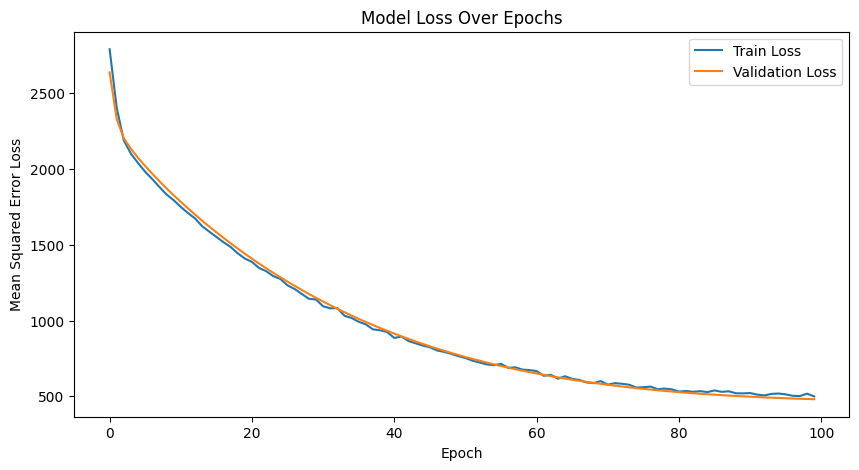

In [8]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 488.5659 
Test MSE Loss: 494.6559753417969
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


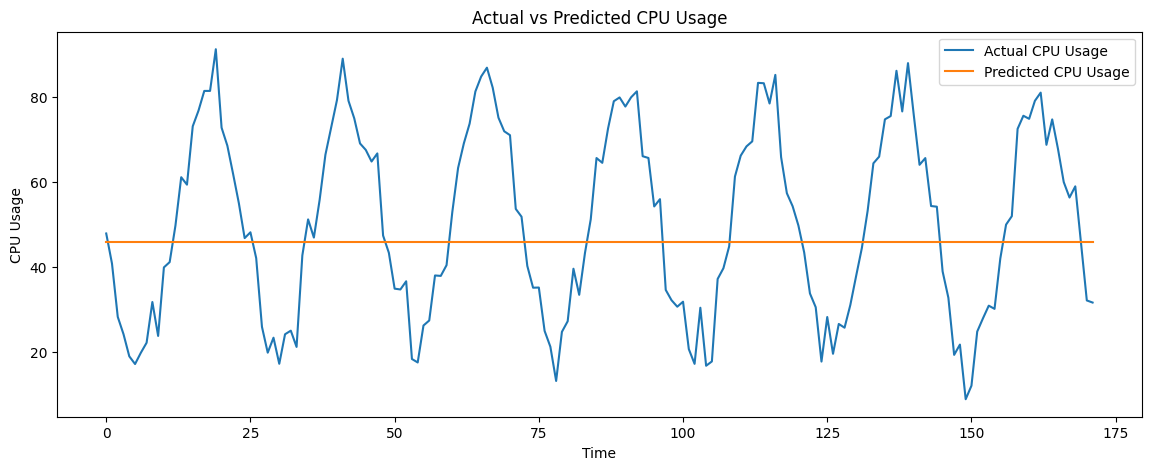

In [9]:
# Evaluate the model on test data
test_loss = model.evaluate(X_test_seq, y_test_seq)
print(f'Test MSE Loss: {test_loss}')

# Make predictions
y_pred = model.predict(X_test_seq)

# Plot actual vs predicted CPU usage
plt.figure(figsize=(14,5))
plt.plot(y_test_seq, label='Actual CPU Usage')
plt.plot(y_pred, label='Predicted CPU Usage')
plt.title('Actual vs Predicted CPU Usage')
plt.xlabel('Time')
plt.ylabel('CPU Usage')
plt.legend()
plt.show()


In [10]:
# Save the trained model
model.save('my_model.keras')

# Save the scaler
scaler_filename = 'scaler.save'
joblib.dump(scaler, scaler_filename)

print("Model and scaler have been saved successfully.")


Model and scaler have been saved successfully.


In [11]:
from google.colab import files
import pandas as pd

# Upload your dataset
uploaded = files.upload()

# Load the dataset into a pandas DataFrame
data = pd.read_csv('/content/cloud_resource_data.csv')


Saving cloud_resource_data.csv to cloud_resource_data (1).csv


In [14]:
import pandas as pd
import joblib

# Load your dataset
data = pd.read_csv('cloud_resource_data.csv')

# Drop the Timestamp column (it can't be scaled)
data_numeric = data.drop(columns=['Timestamp'])

# Load the scaler
scaler = joblib.load('scaler.save')

# Scale the data (numerical columns only)
X_scaled = scaler.transform(data_numeric)

# If your model expects sequences, you may need to reshape the data accordingly
print(X_scaled[:5])  # This will show the scaled version of the first 5 rows


[[ 0.66302087  6.37855962  5.2173913   5.         -5.41750369  8.66360388]
 [ 0.68981667  6.61210823  6.08695652  5.83333333 -4.94386189 12.74779165]
 [ 0.64596899  6.09311132  5.          4.66666667 -5.8911455   7.64255694]
 [ 0.61308323  5.96336209  4.7826087   5.33333333 -5.18068279  5.60046305]
 [ 0.58141547  5.70386364  4.34782609  4.5        -6.1279664   4.57941611]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [15]:
import numpy as np

# Define number of timesteps (same as used during training)
timesteps = 24

# Create sequences from the scaled data
def create_sequences(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps + 1):
        sequences.append(data[i:i + timesteps])
    return np.array(sequences)

# Create sequences
X_test_sequences = create_sequences(X_scaled, timesteps)
print(X_test_sequences.shape)  # Check the shape of the sequences (e.g., (number_of_sequences, 24, number_of_features))


(0,)


In [16]:
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('my_model.keras', custom_objects={'mse': tf.keras.metrics.MeanSquaredError()})


In [18]:
print(X_scaled.shape)  # Check the shape of the scaled data


(8, 6)


In [19]:
if X_scaled.shape[0] >= timesteps:
    X_test_sequences = create_sequences(X_scaled, timesteps)
    print(f"Shape of test sequences: {X_test_sequences.shape}")
else:
    print(f"Not enough data points to create sequences with {timesteps} timesteps.")


Not enough data points to create sequences with 24 timesteps.


In [20]:
if X_test_sequences.shape[0] > 0:
    predictions = model.predict(X_test_sequences)
    print(predictions)
else:
    print("No valid sequences to make predictions on.")


No valid sequences to make predictions on.


In [21]:
print(f"Number of rows in dataset: {X_scaled.shape[0]}")


Number of rows in dataset: 8


In [22]:
# Let's say we reduce the number of timesteps to 3
timesteps = 3

# Create sequences with 3 timesteps instead of 24
if X_scaled.shape[0] >= timesteps:
    X_test_sequences = create_sequences(X_scaled, timesteps)
    print(f"Shape of test sequences: {X_test_sequences.shape}")
else:
    print(f"Not enough data points to create sequences with {timesteps} timesteps.")


Shape of test sequences: (6, 3, 6)


In [23]:
# After creating valid sequences, make predictions
if X_test_sequences.shape[0] > 0:
    predictions = model.predict(X_test_sequences)
    print(predictions)
else:
    print("No valid sequences to make predictions on.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
[[30.068998]
 [30.979996]
 [26.17494 ]
 [25.845324]
 [26.570192]
 [33.6983  ]]


In [24]:
print("Predictions:")
print(predictions)


Predictions:
[[30.068998]
 [30.979996]
 [26.17494 ]
 [25.845324]
 [26.570192]
 [33.6983  ]]


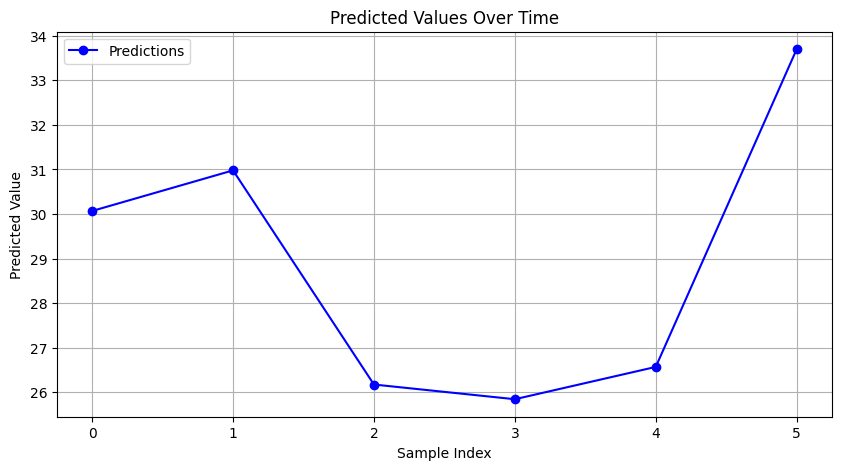

In [32]:
import matplotlib.pyplot as plt

# Sample x-axis data (e.g., time steps or sample indices)
x_axis = range(len(predictions))

# Create a line plot
plt.figure(figsize=(10, 5))
plt.plot(x_axis, predictions, marker='o', linestyle='-', color='b', label='Predictions')
plt.title('Predicted Values Over Time')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Value')
plt.xticks(x_axis)  # Show all sample indices on x-axis
plt.legend()
plt.grid()
plt.show()


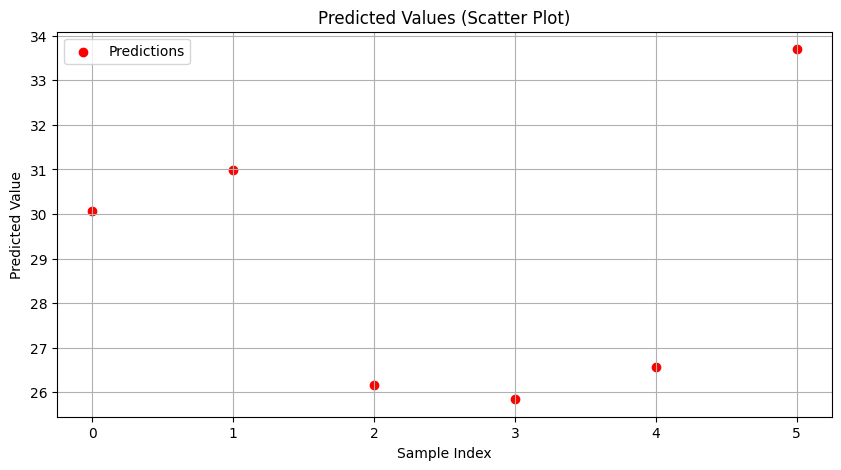

In [33]:
# Create a scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(x_axis, predictions, color='red', label='Predictions')
plt.title('Predicted Values (Scatter Plot)')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Value')
plt.xticks(x_axis)  # Show all sample indices on x-axis
plt.legend()
plt.grid()
plt.show()


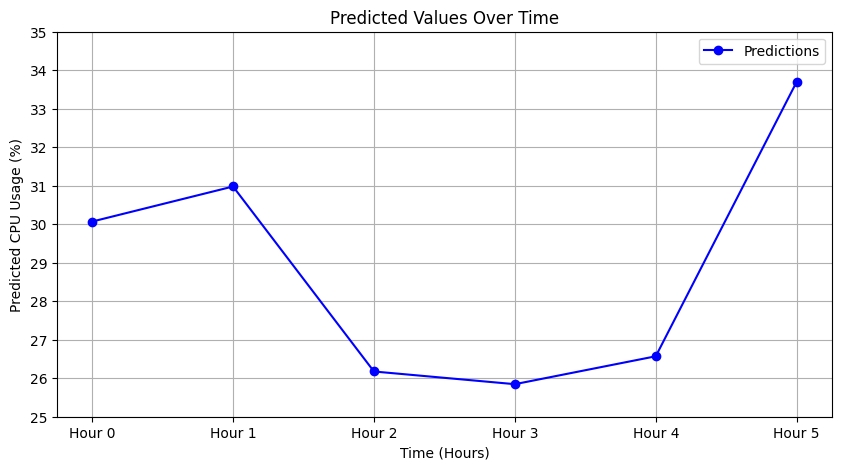

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = np.arange(6)  # Sample indices (0, 1, 2, 3, 4, 5)
predictions = np.array([30.068998, 30.979996, 26.17494, 25.845324, 26.570192, 33.6983])

# Create line plot
plt.figure(figsize=(10, 5))
plt.plot(x, predictions, marker='o', linestyle='-', color='b', label='Predictions')
plt.title('Predicted Values Over Time')
plt.xlabel('Time (Hours)')  # Meaning: Each index represents a time interval
plt.ylabel('Predicted CPU Usage (%)')  # Meaning: The predicted CPU usage value in percentage
plt.xticks(np.arange(0, 6, 1), labels=['Hour 0', 'Hour 1', 'Hour 2', 'Hour 3', 'Hour 4', 'Hour 5'])  # Custom x-ticks
plt.yticks(np.arange(25, 36, 1))  # Custom y-ticks from 25 to 35
plt.grid()
plt.legend()
plt.show()
